### Closing the West Antarctic subsurface heat budget

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from dask.distributed import Client
client = Client(n_workers=16)        
client
rotblau = [[0.4 , 0.  , 0.12], [0.47, 0.02, 0.13], [0.62, 0.07, 0.16], [0.66, 0.16, 0.2],
           [0.8 , 0.3 , 0.27], [0.87, 0.44, 0.35], [0.93, 0.58, 0.45], [0.96, 0.7 , 0.58], 
           [0.98, 0.8 , 0.71], [0.98, 0.94, 0.92], [0.93, 0.95, 0.96], [0.85, 0.91, 0.95],
           [0.76, 0.87, 0.93], [0.64, 0.8 , 0.89], [0.49, 0.72, 0.84], [0.34, 0.62, 0.79], 
           [0.23, 0.53, 0.74], [0.16, 0.44, 0.7] , [0.1 ,0.35, 0.6], [0.05, 0.24, 0.45], [0.02, 0.19, 0.38]]

### Getting the 1000 m isobath shelf mask

CPU times: user 12.6 s, sys: 5.04 s, total: 17.7 s
Wall time: 1min 2s


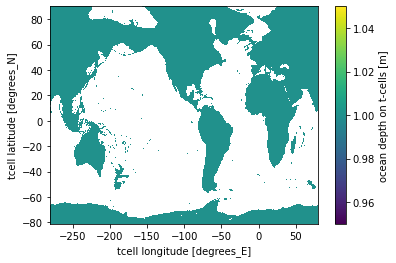

In [2]:
%%time
# first get the shelf mask
base_spin = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output979'
field = xr.open_mfdataset(base_spin + '/ocean/ocean_grid.nc').ht
above1000 = field.where(field >= 1000,1) # set all values smaller than 1000 to 1
above1000_tcells = above1000.where(above1000 < 1000, drop=True) # remove all values bigger than 1000

# now also for velocity cells
field = xr.open_mfdataset(base_spin + '/ocean/ocean_grid.nc').hu; above1000 = field.where(field >= 1000,1); above1000_ucells = above1000.where(above1000 < 1000, drop=False) 
# Wall time: 8.74 s
above1000_tcells.plot()

In [3]:
%%time
base   = ['/g/data/e14/mv7494/access-om2/archive/', '/g/data/e14/mv7494/access-om2/archive/', '/g/data/e14/mv7494/access-om2/archive/']
exp    = ['01deg_jra55_ryf_Control','01deg_jra55_ryf_ENFull', '01deg_jra55_ryf_LNFull']
file   = ['ocean.nc', 'ocean_month.nc', 'ocean_month.nc', 'ocean_heat.nc']

# ----------------------------------------------------------------------------------------------------------------------------- #
depth     = [  23,   47]  # [ 23,   47] = 97.6 m - 1017 m, [24,   40] = 108.9 - 517.6 m                                         #
sel_lat   = [   0,  400]  # [120,  263] = 76.03°S - 70.04°S                                                                     #
sel_lon   = [1299, 2200]  # 150°W - 60°W                                                                                        #
# ----------------------------------------------------------------------------------------------------------------------------- #
rho_0     = 1035          # reference density [1035 kg * m^-3]                                                                  #
C_p       = 3992.1        # reference specific heat capacity [3992.1 J * kg^-1 * K^-1]                                          #
area_t      = xr.open_mfdataset(base[0]+exp[0]+'/output976/ocean/ocean_grid.nc').area_t[                                        #
              sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]                                                                     #
area_u      = xr.open_mfdataset(base[0]+exp[0]+'/output976/ocean/ocean_grid.nc').area_u[                                        #
              sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]                                                                     #
dyt  = xr.open_mfdataset(base[0]+exp[0]+'/output976/ocean/ocean_grid.nc').dyt[sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]     #
dyu  = xr.open_mfdataset(base[0]+exp[0]+'/output976/ocean/ocean_grid.nc').dyu[sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]     #
dxu  = xr.open_mfdataset(base[0]+exp[0]+'/output976/ocean/ocean_grid.nc').dxu[sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]     #

var  = ['temp_submeso',                                                                                                         #
        'temp_tendency',                                                                                # ocean heat tendency   #
        'temp_advection',                                                                               # advection terms       #
        'temp_vdiffuse_diff_cbt', 'temp_nonlocal_KPP',                                                  # vertical mixing terms #
        'sw_heat', 'temp_vdiffuse_sbc', 'sfc_hflux_pme',                                                # surface forcing terms #
        'frazil_3d', 'temp_eta_smooth',                                                                 # surface heat fluxes   #
        'temp_rivermix']                                                                                # surface volume flux   #
# variables in temperature space                                                                                                #
var2 = ['tx_trans_nrho', 'ty_trans_nrho',                                                               # advection terms       #
        'mass_pmepr_on_nrho',                                                                           # surface volume flux   #
        'temp_vdiffuse_diff_cbt_on_nrho', 'temp_nonlocal_KPP_on_nrho',                                  # vertical mixing terms #
        'temp_vdiffuse_sbc_on_nrho', 'sw_heat_on_nrho', 'frazil_on_nrho', 'temp_eta_smooth_on_nrho']    # surface forcing terms #
# ----------------------------------------------------------------------------------------------------------------------------- #

for h in [1]:#range(2):
    if h == 0: depth = [ 0, 47]; print('Calculating OHC budget for surface - 1000 m')
    if h == 1: depth = [23, 47]; print('Calculating OHC budget for 100 - 1000 m')
    dzt   = xr.open_mfdataset(base[0]+exp[0]+'/output976/ocean/ocean_month.nc').dzt[0,depth[0]:depth[1],sel_lat[0]:sel_lat[1],sel_lon[0]:sel_lon[1]]  #

    for e in [1,2]: # loop through the two simulations ENFull and LNFull
        print('Loading in '+ exp[e] + ' for the Eulerian heat budget:')
        print('---------------------------------------------------------------')

        if e == 1: last_output = 985; nr_outputs = 10 # for ENFull, I only have output976-output980
        if e == 2: last_output = 989; nr_outputs = 14

        a = [i for i in range(last_output+1-nr_outputs,last_output+1)] # create integer list
        s = list(range(0,nr_outputs))
        c = []; d = []; f = []; g = []; q = [] # empty list which I fill up; c for control, d for perturbation simulation
        for i in s: # loop through the number of files I would like
            # fill in empty list with integers trailing two zeros (000, 001, 002, ...)       
            f.append(i); f[i] = base[0] + exp[0]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[3] # string with all file locations
            g.append(i); g[i] = base[e] + exp[e]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[3]         
            q.append(i); q[i] = base[0] + exp[0]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[1]         
        
        average_DT = xr.open_mfdataset(q, decode_times = True).average_DT.mean('time').values.astype('int') / 1e9 # average time in seconds per month (the output is saved in ns, that's why /1e9) 

        for v in range(len(var)): # loop through the eight diagnostics I need to balance the heat budget
            print(var[v])
            if v in [0, 1, 2, 3, 4, 5, 6, 8, 10]:
                variable_clim = xr.open_mfdataset(f,combine='by_coords',chunks={'time': 1},decode_times = True)[
                    var[v]][:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
                variable      = xr.open_mfdataset(g,combine='by_coords',chunks={'time': 1},decode_times = True)[
                    var[v]][:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]

            if v in [7, 9]: # these two fields (sfc_hflux_pme & temp_eta_smooth) are only 3D (time, latitude, longitude)
                variable_clim = xr.open_mfdataset(f,combine='by_coords',chunks={'time': 1},decode_times = True)[
                    var[v]][:, sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
                variable      = xr.open_mfdataset(g,combine='by_coords',chunks={'time': 1},decode_times = True)[
                    var[v]][:, sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]  

            # -------------------------------------------------------------------------------------- #
            variable = ((variable - variable_clim) * above1000_tcells * area_t) # calculate anomalies by removing the control and multiply with shelf mask
            # -------------------------------------------------------------------------------------- #

            if v ==  0: temp_submeso           = (variable * average_DT).sum(['yt_ocean', 'xt_ocean', 'st_ocean']).load() # calculate time series for each flux
            if v ==  1: temp_tendency          = (variable * average_DT).sum(['yt_ocean', 'xt_ocean', 'st_ocean']).load()
            if v ==  2: temp_advection         = (variable * average_DT).sum(['yt_ocean', 'xt_ocean','st_ocean']).load()
            if v ==  3: temp_vdiffuse_diff_cbt = (variable * average_DT).sum(['yt_ocean', 'xt_ocean','st_ocean']).load()
            if v ==  4: temp_nonlocal_KPP      = (variable * average_DT).sum(['yt_ocean', 'xt_ocean','st_ocean']).load()
            if v ==  5: sw_heat                = (variable * average_DT).sum(['yt_ocean', 'xt_ocean','st_ocean']).load()
            if v ==  6: temp_vdiffuse_sbc      = (variable * average_DT).sum(['yt_ocean', 'xt_ocean','st_ocean']).load()
            if v ==  7: sfc_hflux_pme          = (variable * average_DT).sum(['yt_ocean', 'xt_ocean']).load()
            if v ==  8: frazil_3d              = (variable * average_DT).sum(['yt_ocean', 'xt_ocean','st_ocean']).load()
            if v ==  9: temp_eta_smooth        = (variable * average_DT).sum(['yt_ocean', 'xt_ocean']).load()
            if v == 10: temp_rivermix          = (variable * average_DT).sum(['yt_ocean', 'xt_ocean','st_ocean']).load()         

        if h == 1 and e == 1:
            temp_submeso_EN_100_down           = temp_submeso;            temp_tendency_EN_100_down          = temp_tendency
            temp_advection_EN_100_down         = temp_advection;          temp_vdiffuse_diff_cbt_EN_100_down = temp_vdiffuse_diff_cbt
            temp_nonlocal_KPP_EN_100_down      = temp_nonlocal_KPP;       sw_heat_EN_100_down                = sw_heat
            temp_vdiffuse_sbc_EN_100_down      = temp_vdiffuse_sbc;       sfc_hflux_pme_EN_100_down          = sfc_hflux_pme;
            frazil_3d_EN_100_down              = frazil_3d;               temp_eta_smooth_EN_100_down        = temp_eta_smooth
            temp_rivermix_EN_100_down          = temp_rivermix
        if h == 1 and e == 2:
            temp_submeso_LN_100_down           = temp_submeso;            temp_tendency_LN_100_down          = temp_tendency
            temp_advection_LN_100_down         = temp_advection;          temp_vdiffuse_diff_cbt_LN_100_down = temp_vdiffuse_diff_cbt
            temp_nonlocal_KPP_LN_100_down      = temp_nonlocal_KPP;        sw_heat_LN_100_down                = sw_heat
            temp_vdiffuse_sbc_LN_100_down      = temp_vdiffuse_sbc;        sfc_hflux_pme_LN_100_down          = sfc_hflux_pme;
            frazil_3d_LN_100_down              = frazil_3d;                temp_eta_smooth_LN_100_down        = temp_eta_smooth
            temp_rivermix_LN_100_down          = temp_rivermix
        print('---------------------------------------------------------------')
# Wall time: 3 min 43s

Calculating OHC budget for 100 - 1000 m
Loading in 01deg_jra55_ryf_ENFull for the Eulerian heat budget:
---------------------------------------------------------------
temp_submeso
temp_tendency
temp_advection
temp_vdiffuse_diff_cbt
temp_nonlocal_KPP
sw_heat
temp_vdiffuse_sbc
sfc_hflux_pme
frazil_3d
temp_eta_smooth
temp_rivermix
---------------------------------------------------------------
Loading in 01deg_jra55_ryf_LNFull for the Eulerian heat budget:
---------------------------------------------------------------
temp_submeso
temp_tendency
temp_advection
temp_vdiffuse_diff_cbt
temp_nonlocal_KPP
sw_heat
temp_vdiffuse_sbc
sfc_hflux_pme
frazil_3d
temp_eta_smooth
temp_rivermix
---------------------------------------------------------------
CPU times: user 57.6 s, sys: 6.49 s, total: 1min 4s
Wall time: 2min 49s


### Plotting the heat budget terms

CPU times: user 69.5 ms, sys: 5.14 ms, total: 74.6 ms
Wall time: 69.8 ms


(-3.2, 1.6)

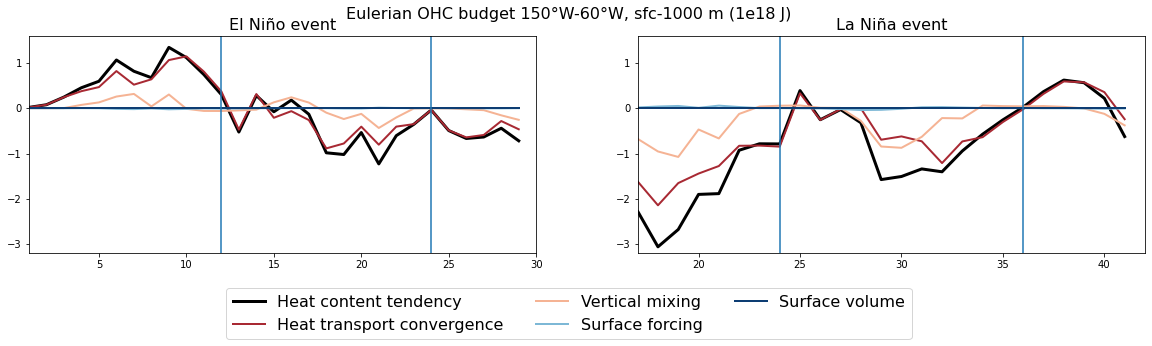

In [4]:
%%time
fig = plt.figure(figsize=(20,4)); plt.suptitle('Eulerian OHC budget 150°W-60°W, sfc-1000 m (1e18 J)', fontsize=16)
ax1 = plt.subplot(1,2,1); plt.title('El Niño event', fontsize=16)
plt.plot(temp_tendency_EN_100_down/1e19,                                                               label = 'Heat content tendency',      linewidth = 3, color = 'k')
plt.plot(temp_advection_EN_100_down/1e19,                                                              label = 'Heat transport convergence', linewidth = 2, color = rotblau[3])
plt.plot((temp_vdiffuse_diff_cbt_EN_100_down+temp_nonlocal_KPP_EN_100_down)/1e19,                      label = 'Vertical mixing',            linewidth = 2, color = rotblau[7])
plt.plot((temp_submeso_EN_100_down+temp_vdiffuse_sbc_EN_100_down+sw_heat_EN_100_down+temp_eta_smooth_EN_100_down+frazil_3d_EN_100_down)/1e19, label = 'Surface forcing',            linewidth = 2, color = rotblau[14])
plt.plot(temp_rivermix_EN_100_down/1e19,                                                               label = 'Surface volume',             linewidth = 2, color = rotblau[19])

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, fontsize=16, ncol=3, bbox_to_anchor=(.5, -.2), loc='lower center')
plt.axvline(12); plt.axvline(24); plt.xlim([1,30]); plt.ylim([-3.2,1.6])

ax1 = plt.subplot(1,2,2); plt.title('La Niña event', fontsize=16)
plt.plot(temp_tendency_LN_100_down/1e19,                                                               linewidth = 3, color = 'k')
plt.plot(temp_advection_LN_100_down/1e19,                                                              linewidth = 2, color = rotblau[3])
plt.plot((temp_vdiffuse_diff_cbt_LN_100_down+temp_nonlocal_KPP_LN_100_down)/1e19,                               linewidth = 2, color = rotblau[7])
plt.plot((temp_submeso_LN_100_down+temp_vdiffuse_sbc_LN_100_down+sw_heat_LN_100_down+temp_eta_smooth_LN_100_down+frazil_3d_LN_100_down)/1e19, linewidth = 2, color = rotblau[14])
plt.plot(temp_rivermix_LN_100_down/1e19,                                                               linewidth = 2, color = rotblau[19])
plt.axvline(24); plt.axvline(36); plt.xlim([17,42]); plt.ylim([-3.2,1.6])

### Next step, decomposing the heat transport convergence into the vertical, along- and across-shelf heat fluxes along with uncertainties

In [5]:
%%time
exp    = ['01deg_jra55_ryf_Control','01deg_jra55_ryf_ENFull', '01deg_jra55_ryf_LNFull']
file   = ['ocean_month.nc', 'ocean_month.nc', 'ocean_month.nc']
region = ['Amundsen Sea', 'Bellingshausen Sea']

# ---------------------------------------------------------------------------------- #
print('Calculating     100 - 1000 m anoms'); depth = [23, 47] # 97.6 - 1017 m
for e in [1,2]: # loop through the two simulations ENFull and LNFull
    print(exp[e])
    if e == 1: last_output = 985; nr_outputs = 10 # for ENFull, I only have output976-output980
    if e == 2: last_output = 989; nr_outputs = 14

    a = [i for i in range(last_output+1-nr_outputs,last_output+1)] # create integer list
    s = list(range(0,nr_outputs))
    c = []; d = []; t = []; u = []; q = [] # empty list which I fill up; c for control, d for perturbation simulation
    for i in s: # loop through the number of files I would like
        # fill in empty list with integers trailing two zeros (000, 001, 002, ...)
        c.append(i); c[i] = base[0] + exp[0]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[0] # string with all file locations
        d.append(i); d[i] = base[e] + exp[e]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[e] 

        t.append(i); t[i] = base[0] + exp[0]+'/output'+str(a[i]).zfill(3) + '/ocean/ocean_month.nc'
        u.append(i); u[i] = base[e] + exp[e]+'/output'+str(a[i]).zfill(3) + '/ocean/ocean_month.nc'

        q.append(i); q[i] = base[0] + exp[0]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[1]         
    average_DT = xr.open_mfdataset(q, decode_times = True).average_DT.mean('time').values.astype('int') / 1e9 # average time in seconds per month (the output is saved in ns, that's why /1e9) 

    temp_clim   = xr.open_mfdataset(c,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},
                                    decode_times = True).temp[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]] # open data sets
    temp        = xr.open_mfdataset(d,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},
                                    decode_times = True).temp[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]

    wt_clim   = xr.open_mfdataset(c,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},
                                  decode_times = True).wt[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
    wt        = xr.open_mfdataset(d,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},
                                  decode_times = True).wt[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]

    # the same for the two velocities
    u_clim   = xr.open_mfdataset(c,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},
                                 decode_times = True).u[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
    u        = xr.open_mfdataset(d,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},
                                 decode_times = True).u[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
    v_clim   = xr.open_mfdataset(c,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},
                                 decode_times = True).v[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
    v        = xr.open_mfdataset(d,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},
                                 decode_times = True).v[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]

    dzt      = xr.open_mfdataset(d,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},
                                 decode_times = True).dzt[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
    if e == 1: 
        temp_EN_anom = (temp  - temp_clim)
        wt_EN_anom   = (wt    - wt_clim)
        u_EN_anom    = (u     - u_clim)
        v_EN_anom    = (v     - v_clim)
        dzu_EN       = dzt.interp(xt_ocean = u.xu_ocean.values, yt_ocean = u.yu_ocean.values, method="nearest").rename({'xt_ocean': 'xu_ocean', 'yt_ocean': 'yu_ocean'})
    if e == 2: 
        temp_LN_anom = (temp  - temp_clim)
        wt_LN_anom   = (wt    - wt_clim)
        u_LN_anom    = (u     - u_clim)
        v_LN_anom    = (v     - v_clim)
        dzu_LN       = dzt.interp(xt_ocean = u.xu_ocean.values, yt_ocean = u.yu_ocean.values, method="nearest").rename({'xt_ocean': 'xu_ocean', 'yt_ocean': 'yu_ocean'})
print('----------------------------------')
# Wall time: 30.4 s

Calculating     100 - 1000 m anoms
01deg_jra55_ryf_ENFull
01deg_jra55_ryf_LNFull
----------------------------------
CPU times: user 25.4 s, sys: 2.48 s, total: 27.9 s
Wall time: 27 s


### The climatological temperature range across the volume in the West Antarctic region

CPU times: user 4.41 s, sys: 768 ms, total: 5.18 s
Wall time: 17.4 s


2.5076904296875

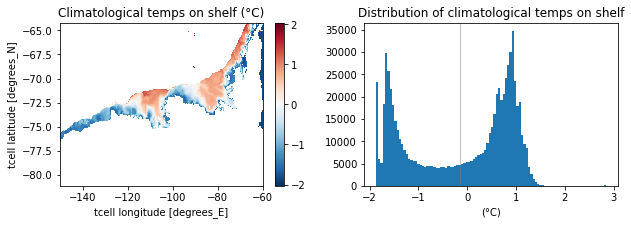

In [6]:
%%time
# first, get climatological shelf temperature range in °C
clim = ((temp_clim*above1000_tcells).mean('time') - 273.15) # the climatological temperatures across the West Antarctic subsurface volume
clim_mean  = np.nanmean(clim)
clim_range = np.nanpercentile(clim, 84.1) - np.nanpercentile(clim, 15.9) # the interquartile (68.2 % of data) range

plt.figure(figsize=(10,3))
plt.subplot(1,2,1); clim.mean('st_ocean').plot(); plt.title('Climatological temps on shelf (°C)')
plt.subplot(1,2,2); clim.plot.hist(bins=100); plt.axvline(clim_mean, lw=.5,c='grey'); plt.title('Distribution of climatological temps on shelf'); plt.xlabel('(°C)')
clim_range # 2.51 °C; that means 68.2% of the temperatures are within +/- 1.255 °C on either side of the mean
# Wall time: 53.1

In [7]:
clim_range = 1.5

### First, the vertical heat flux across 100 m depth into the subsurface shelf region

CPU times: user 7.02 s, sys: 727 ms, total: 7.74 s
Wall time: 29.8 s


(-3.2, 1.6)

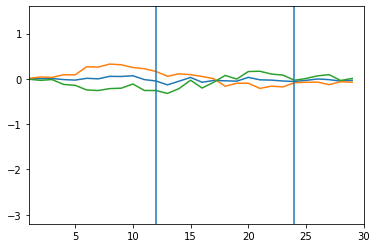

In [8]:
%%time
# get the grid cell area and ocean depth, select West Antarctic shelf region and interpolate to dTdz grid
base_grid = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output979/ocean/ocean'

above1000 = above1000_tcells[sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]] # the shelf mask for West Antarctica

for f in range(2): # loop through both El Niño and La Niña
    if f == 0: wt = wt_EN_anom; temp = temp_EN_anom
    if f == 1: wt = wt_LN_anom; temp = temp_LN_anom
    
    # here the calculation of the vertical heat flux (kg m-3 * J kg-1 K-1 * m s-1 * K * m2 * s) = (J) --------------------------------------------------- #
    vertical_heat_flux             = (rho_0 * C_p * wt[:,0,:,:] * temp[:,0,:,:] * area_t * average_DT * above1000).sum(['yt_ocean', 'xt_ocean']).load()
    # ... and now also the uncertainties
    vertical_heat_flux_uncertainty = (rho_0 * C_p * wt[:,0,:,:] * (clim_range/2) * area_t * average_DT * above1000).sum(['yt_ocean', 'xt_ocean']).load()
    
    if f == 0: vertical_heat_flux_EN = vertical_heat_flux; vertical_heat_flux_uncertainty_EN = vertical_heat_flux_uncertainty
    if f == 1: vertical_heat_flux_LN = vertical_heat_flux; vertical_heat_flux_uncertainty_LN = vertical_heat_flux_uncertainty

plt.plot(vertical_heat_flux_EN/1e19)
plt.plot((vertical_heat_flux_EN + vertical_heat_flux_uncertainty_EN)/1e19)
plt.plot((vertical_heat_flux_EN - vertical_heat_flux_uncertainty_EN)/1e19)
plt.axvline(12); plt.axvline(24); plt.xlim([1,30]); plt.ylim([-3.2,1.6])
# Wall time: 23.2 s

### Second, the along-shelf heat flux across the combined 60°W + 150°W interface

CPU times: user 13.7 s, sys: 1.43 s, total: 15.1 s
Wall time: 58.5 s


(-3.2, 1.6)

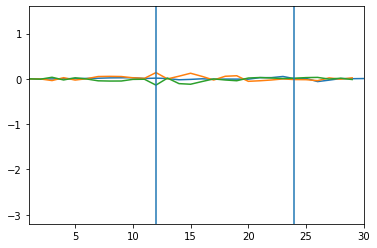

In [9]:
%%time
# get the grid cell area and ocean depth, select West Antarctic shelf region and interpolate to dTdz grid

above1000 = above1000_tcells[sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]] # the shelf mask for West Antarctica

# interpolate t-cell thickness onto u-grid
dzu = dzt[:,:,:].interp(xt_ocean=u_EN_anom.xu_ocean.values,yt_ocean=u_EN_anom.yu_ocean.values,method="nearest").rename({'xt_ocean':'xu_ocean','yt_ocean':'yu_ocean'})

for f in range(2): # loop through both El Niño and La Niña
    if f == 0: u = u_EN_anom; temp = temp_EN_anom.interp(
        xt_ocean=u_EN_anom.xu_ocean.values,yt_ocean=u_EN_anom.yu_ocean.values,method="nearest").rename({'xt_ocean':'xu_ocean','yt_ocean':'yu_ocean'})
    if f == 1: u = u_LN_anom; temp = temp_LN_anom.interp(
        xt_ocean=u_LN_anom.xu_ocean.values,yt_ocean=u_LN_anom.yu_ocean.values,method="nearest").rename({'xt_ocean':'xu_ocean','yt_ocean':'yu_ocean'})
    
    # here the calculation of the along-shelf heat flux (kg m-3 * J kg-1 K-1 * m s-1 * K * m2 * s) = (J) ------------------------------------------------ #
    along_heat_flux             = (rho_0 * C_p * u[:,:,:,0] * temp[:,:,:,0] * dzu[:,:,:,0] * dyu[:,0] * average_DT * above1000_ucells[sel_lat[0]:sel_lat[1]:,1299]).sum(['st_ocean', 'yu_ocean']).load() + (
                                   rho_0 * C_p * u[:,:,:,-1] * temp[:,:,:,-1] * dzu[:,:,:,-1] * dyu[:,-1] * average_DT * above1000_ucells[sel_lat[0]:sel_lat[1]:,2200]).sum(['st_ocean', 'yu_ocean']).load()

    # ... and now also the uncertainties
    along_heat_flux_uncertainty = (rho_0 * C_p * u[:,:,:,0] * (clim_range/2) * dzu[:,:,:,0] * dyu[:,0] * average_DT * above1000_ucells[sel_lat[0]:sel_lat[1]:,1299]).sum(['st_ocean', 'yu_ocean']).load() + (
                                   rho_0 * C_p * u[:,:,:,-1] * (clim_range/2) * dzu[:,:,:,-1] * dyu[:,-1] * average_DT * above1000_ucells[sel_lat[0]:sel_lat[1]:,2200]).sum(['st_ocean', 'yu_ocean']).load()

    if f == 0: along_heat_flux_EN = along_heat_flux; along_heat_flux_uncertainty_EN = along_heat_flux_uncertainty
    if f == 1: along_heat_flux_LN = along_heat_flux; along_heat_flux_uncertainty_LN = along_heat_flux_uncertainty

plt.plot(along_heat_flux/1e19)
plt.plot((along_heat_flux_EN + along_heat_flux_uncertainty_EN)/1e19)
plt.plot((along_heat_flux_EN - along_heat_flux_uncertainty_EN)/1e19)
plt.axvline(12); plt.axvline(24); plt.xlim([1,30]); plt.ylim([-3.2,1.6])
# Wall time: 3min 16s

### Third, the across-shelf transport

CPU times: user 209 ms, sys: 30.7 ms, total: 240 ms
Wall time: 210 ms


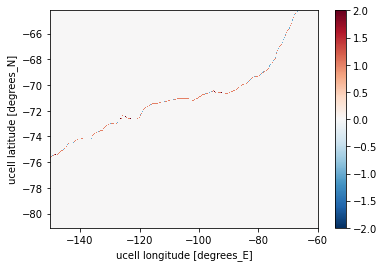

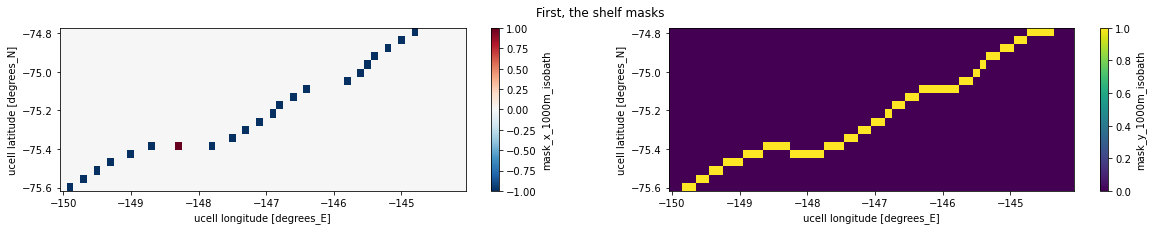

In [38]:
%%time
# loading in the transport masks from Claire's script called 'Cross-contour_transport.ipynb'
# her original script is in the COSIMA recipe repo: https://cosima-recipes.readthedocs.io/en/latest/DocumentedExamples/Cross-contour_transport.html
base_mask = '/g/data/e14/mv7494/ACCESS-OM2-01_transport_masks/'
mask_x_transport_ucells = xr.open_dataset(base_mask + 'mask_x_transport_ucells_1000m_isobath_ACCESS-OM2-01_from90S.nc').mask_x_1000m_isobath.rename(
    {'y_ocean': 'yu_ocean', 'x_ocean': 'xu_ocean'})[sel_lat[0]:sel_lat[1],sel_lon[0]:sel_lon[1]]
mask_y_transport_ucells = xr.open_dataset(base_mask + 'mask_y_transport_ucells_1000m_isobath_ACCESS-OM2-01_from90S.nc').mask_y_1000m_isobath.rename(
    {'y_ocean': 'yu_ocean', 'x_ocean': 'xu_ocean'})[sel_lat[0]:sel_lat[1],sel_lon[0]:sel_lon[1]]
(mask_x_transport_ucells+mask_y_transport_ucells).plot()
# mask_x_transport_ucells = mask_x_transport_ucells.where(mask_x_transport_ucells != -1, 1) # replace all -1 with 1
# mask_x_transport_ucells = mask_x_transport_ucells.where(mask_x_transport_ucells != 0)     # replace all zero with nan
# mask_y_transport_ucells = mask_y_transport_ucells.where(mask_y_transport_ucells != 0)     # replace all zero with nan

plt.figure(figsize=(20,3));plt.suptitle('First, the shelf masks')
plt.subplot(1,2,1); mask_x_transport_ucells[130:150,:60].plot();plt.subplot(1,2,2); mask_y_transport_ucells[130:150,:60].plot()

CPU times: user 8.05 s, sys: 1.01 s, total: 9.06 s
Wall time: 42.9 s


Text(24, -2.5, 'end El Niño')

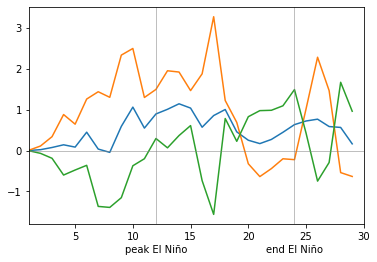

In [39]:
%%time
# dzu = xr.open_dataset('/g/data/e14/mv7494/access-om2/archive/01deg_jra55_ryf_dzu/output976/ocean/ocean_month.nc').dzu[0,depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]

# interpolate t-cell thickness onto u-grid
dzu = dzt.interp(xt_ocean=u_EN_anom.xu_ocean.values,yt_ocean=u_EN_anom.yu_ocean.values,method="nearest").rename({'xt_ocean':'xu_ocean','yt_ocean':'yu_ocean'})

for f in range(2): # loop through both El Niño and La Niña
    if f == 0:
        u = u_EN_anom; v = v_EN_anom
        # interpolate temperature onto u-grid
        temp = temp_EN_anom.interp(xt_ocean=u_EN_anom.xu_ocean.values,yt_ocean=u_EN_anom.yu_ocean.values,method="nearest").rename({'xt_ocean':'xu_ocean','yt_ocean':'yu_ocean'})
    if f == 1: 
        u = u_LN_anom; v = v_LN_anom
        temp = temp_LN_anom.interp(xt_ocean=u_LN_anom.xu_ocean.values,yt_ocean=u_LN_anom.yu_ocean.values,method="nearest").rename({'xt_ocean':'xu_ocean','yt_ocean':'yu_ocean'})
    
    # here the calculation of the across-shelf heat flux (kg m-3 * J kg-1 K-1 * m s-1 * K * m2 * s) = (J) ----------------------------------------------- #
    across_heat_flux = ((rho_0 * C_p * u * temp * dzu * dyu * average_DT * mask_x_transport_ucells) + 
                        (rho_0 * C_p * v * temp * dzu * dxu * average_DT * mask_y_transport_ucells)).sum(['st_ocean', 'yu_ocean', 'xu_ocean']).load()
    
    # plus the uncertainty ------------------------------------------------------------------------------------------------------------------------------ #
    across_heat_flux_uncertainty = ((rho_0 * C_p * u * (clim_range/2) * dzu * dyu * average_DT * mask_x_transport_ucells) + 
                                    (rho_0 * C_p * v * (clim_range/2) * dzu * dxu * average_DT * mask_y_transport_ucells)).sum(['st_ocean', 'yu_ocean', 'xu_ocean']).load()
    
    if f == 0: across_heat_flux_EN = across_heat_flux; across_heat_flux_uncertainty_EN = across_heat_flux_uncertainty
    if f == 1: across_heat_flux_LN = across_heat_flux; across_heat_flux_uncertainty_LN = across_heat_flux_uncertainty        
    
plt.plot(across_heat_flux_EN*-1/1e19) # multiply with -1 to get the poleward heat flux instead of the across-shelf heat flux away from the continent
plt.plot((across_heat_flux_EN+across_heat_flux_uncertainty_EN)*-1/1e19) # multiply with -1 to get the poleward heat flux instead of the across-shelf heat flux away from the continent
plt.plot((across_heat_flux_EN-across_heat_flux_uncertainty_EN)*-1/1e19) # multiply with -1 to get the poleward heat flux instead of the across-shelf heat flux away from the continent
plt.axhline(0,c='grey',lw=.5); plt.axvline(12,c='grey',lw=.5); plt.axvline(24,c='grey',lw=.5); plt.xlim([1,30]); #plt.ylim([-3.2,1.6])
plt.text(12, -2.5, 'peak El Niño', ha='center'); plt.text(24, -2.5, 'end El Niño', ha='center')
# Wall time: 2min 26s

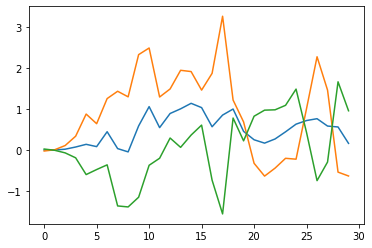

In [40]:
plt.plot(across_heat_flux_EN*-1/1e19) # multiply with -1 to get the poleward heat flux instead of the across-shelf heat flux away from the continent
plt.plot((across_heat_flux_EN+across_heat_flux_uncertainty_EN)*-1/1e19) # multiply with -1 to get the poleward heat flux instead of the across-shelf heat flux away from the continent
plt.plot((across_heat_flux_EN-across_heat_flux_uncertainty_EN)*-1/1e19) # multiply with -1 to get the poleward heat flux instead of the across-shelf heat flux away from the continent

CPU times: user 85.8 ms, sys: 13.2 ms, total: 99 ms
Wall time: 93.3 ms


Text(0, 0.5, '(10$^{19}$ J)')

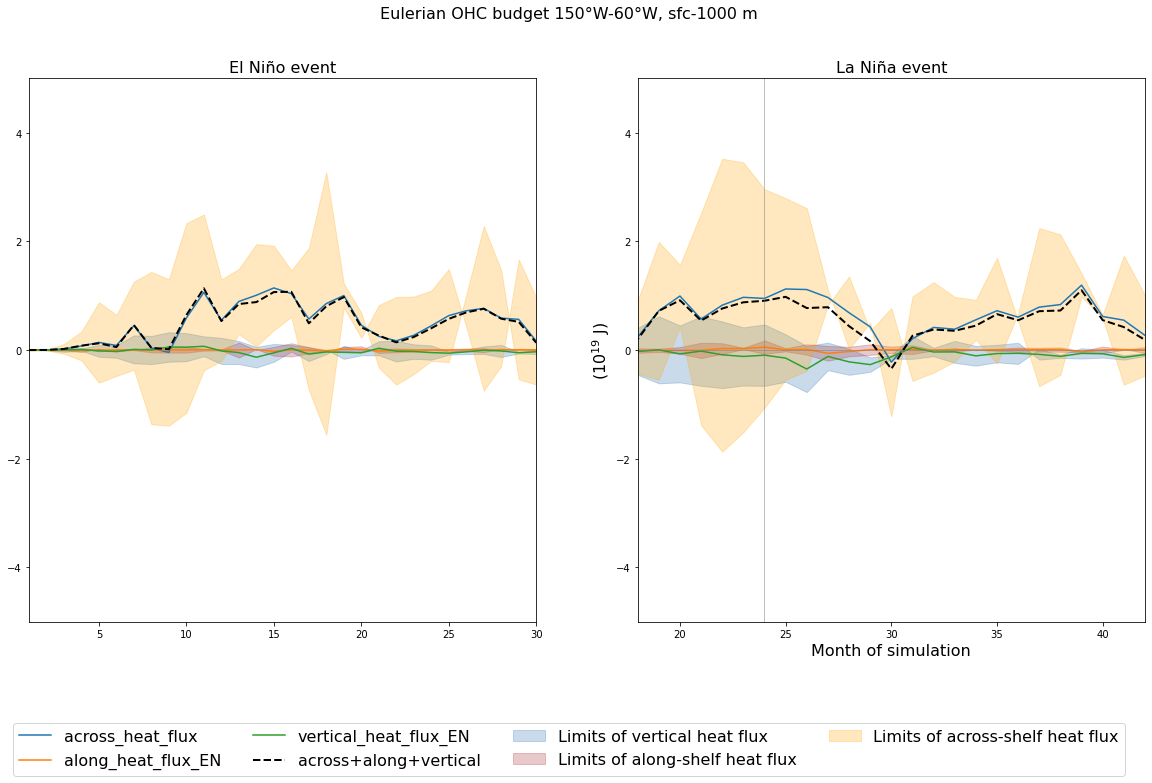

In [42]:
%%time

fig = plt.figure(figsize=(20,10)); plt.suptitle('Eulerian OHC budget 150°W-60°W, sfc-1000 m', fontsize=16)
for f in range(2):
    if f == 0:
        title_str = 'El Niño'
        time     = np.linspace(1,len(temp_advection_EN_100_down), len(temp_advection_EN_100_down))
        adv      = temp_advection_EN_100_down
        
        across   = across_heat_flux_EN;   across_uncertainty   = across_heat_flux_uncertainty_EN
        along    = along_heat_flux_EN;    along_uncertainty    = along_heat_flux_uncertainty_EN
        vertical = vertical_heat_flux_EN; vertical_uncertainty = vertical_heat_flux_uncertainty_EN
        
        xlimits = [1,30]
    if f == 1: 
        time = np.linspace(1,len(temp_advection_LN_100_down), len(temp_advection_LN_100_down))
        title_str = 'La Niña'
        time     = np.linspace(1,len(temp_advection_LN_100_down), len(temp_advection_LN_100_down))
        adv      = temp_advection_LN_100_down
        
        across   = across_heat_flux_LN;   across_uncertainty   = across_heat_flux_uncertainty_LN
        along    = along_heat_flux_LN;    along_uncertainty    = along_heat_flux_uncertainty_LN
        vertical = vertical_heat_flux_LN; vertical_uncertainty = vertical_heat_flux_uncertainty_LN
        
        xlimits = [18,42]

    ax1 = plt.subplot(1,2,f+1); plt.title(title_str + ' event', fontsize=16)
    # plt.plot(time, adv/1e19,                                                              label = 'Heat transport convergence', lw = 2, color = 'k')

    plt.plot(time, across*-1/1e19, label='across_heat_flux') # multiply with -1 to get the poleward heat flux instead of the across-shelf heat flux away from the continent
    plt.plot(time, along/1e19, label='along_heat_flux_EN')
    plt.plot(time, vertical/1e19, label='vertical_heat_flux_EN')

    # the sum of all three components
    # plt.plot(time, ((across*-1)+along+vertical)/1e19, linestyle='--', lw = 2, color = 'k', label='across+along+vertical')

    # And now also shading the uncertainty intervalls
    ax1.fill_between(time, (vertical + vertical_uncertainty)/1e19, 
                     (vertical - vertical_uncertainty)/1e19,  color=rotblau[17], alpha=.25, label= 'Limits of vertical heat flux')

    ax1.fill_between(time, (along + along_uncertainty)/1e19, 
                     (along - along_uncertainty)/1e19,  color=rotblau[3], alpha=.25, label= 'Limits of along-shelf heat flux')

    ax1.fill_between(time, (across+across_uncertainty)*-1/1e19, 
                     (across-across_uncertainty)*-1/1e19,  color='orange', alpha=.25, label= 'Limits of across-shelf heat flux')

    plt.xlim(xlimits); plt.ylim([-5,5])
    # plt.text(12, -2.5, 'peak El Niño', ha='center'); plt.text(24, -2.5, 'end El Niño', ha='center')
    
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, fontsize=16, ncol=4, bbox_to_anchor=(.5,-.1), loc='lower center')
plt.axhline(0,c='grey',lw=.5); plt.axvline(12,c='grey',lw=.5); plt.axvline(24,c='grey',lw=.5)


plt.xlabel('Month of simulation', fontsize=16); plt.ylabel('(10$^{19}$ J)', fontsize=16)

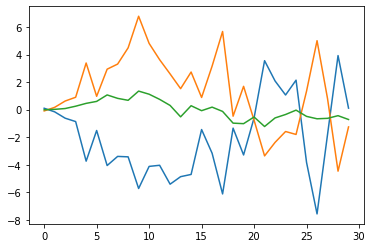

In [36]:
# And now also shading the uncertainty intervalls
upper_bnds = (across_heat_flux_EN + across_heat_flux_uncertainty_EN)/1e19*-1 + (vertical_heat_flux_EN + vertical_heat_flux_uncertainty_EN)/1e19 + (along_heat_flux_EN + along_heat_flux_uncertainty_EN)/1e19
lower_bnds = (across_heat_flux_EN - across_heat_flux_uncertainty_EN)/1e19*-1 + (vertical_heat_flux_EN - vertical_heat_flux_uncertainty_EN)/1e19 + (along_heat_flux_EN - along_heat_flux_uncertainty_EN)/1e19

plt.plot(upper_bnds)
plt.plot(lower_bnds)
plt.plot(temp_tendency_EN_100_down/1e19)

In [37]:

ax1.fill_between(time, (vertical_heat_flux_EN + vertical_heat_flux_uncertainty_EN)/1e19, 
                 (vertical_heat_flux_EN - vertical_heat_flux_uncertainty_EN)/1e19,  color=rotblau[17], alpha=.25, label= 'Limits of vertical heat flux')

ax1.fill_between(time, (along_heat_flux_EN + along_heat_flux_uncertainty_EN)/1e19, 
                 (along_heat_flux_EN - along_heat_flux_uncertainty_EN)/1e19,  color=rotblau[3], alpha=.25, label= 'Limits of vertical heat flux')

ax1.fill_between(time, (across_heat_flux_EN + across_heat_flux_uncertainty_EN)/1e19*-1, 
                 (across_heat_flux_EN - across_heat_flux_uncertainty_EN)/1e19*-1,  color='orange', alpha=.25, label= 'Limits of across-shelf heat flux')

ValueError: operands could not be broadcast together with shapes (42,) (30,) 